In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class RopelessMLA(nn.Module):
    def __init__(self, d_model, n_heads, kv_latent_dim):
        super().__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        self.dh = d_model // n_heads  # Head dimension

        # Linear projections
        self.w_q = nn.Linear(d_model, d_model, bias=False)
        self.w_dkv = nn.Linear(d_model, kv_latent_dim, bias=False)
        self.w_uk = nn.Linear(d_model, kv_latent_dim, bias=False)
        self.w_uv = nn.Linear(kv_latent_dim, d_model, bias=False)
        self.w_o = nn.Linear(d_model, d_model, bias=False)

        self.ln = nn.LayerNorm(kv_latent_dim)
        self.register_buffer('absorbed_k', None)  # Precomputed Wq @ Wuk.T

    def forward(self, x, kv_cache=None, past_length=0):
        B, S, D = x.size()

        if self.absorbed_k is None:
            absorbed = self.w_q.weight @ self.w_uk.weight.T  # [D, D] @ [D, latent_dim] = [D, latent_dim]
            self.absorbed_k = absorbed.view(self.n_heads, self.dh, -1)  # [n_heads, dh, latent_dim]

        new_c_kv = self.ln(self.w_dkv(x))  # [B, S, latent_dim]

        if kv_cache is None:
            c_kv = new_c_kv
        else:
            c_kv = torch.cat([kv_cache, new_c_kv], dim=1)  # [B, S_total, latent_dim]

        S_full = c_kv.size(1)

        v_full = self.w_uv(c_kv)  # [B, S_full, D]
        v = v_full.view(B, S_full, self.n_heads, self.dh).transpose(1, 2)  # [B, n_heads, S_full, dh]

        q = x.view(B, S, self.n_heads, self.dh).transpose(1, 2)  # [B, n_heads, S, dh]

        attn_scores = torch.zeros(B, self.n_heads, S, S_full, device=x.device)

        for h in range(self.n_heads):
            tmp = torch.matmul(q[:, h], self.absorbed_k[h])  # [B, S, latent_dim]
            attn_scores[:, h] = torch.bmm(tmp, c_kv.transpose(1, 2))  # [B, S, S_full]

        attn_scores = attn_scores / math.sqrt(self.dh)

        mask = torch.tril(torch.ones(S, S_full, device=x.device), diagonal=past_length)
        attn_scores = attn_scores.masked_fill(mask.view(1, 1, S, S_full) == 0, float('-inf'))

        attn_weights = F.softmax(attn_scores, dim=-1)

        out_heads = []
        for h in range(self.n_heads):
            context_h = torch.matmul(attn_weights[:, h], v[:, h])  # [B, S, dh]
            out_heads.append(context_h)

        out = torch.cat(out_heads, dim=-1)  # [B, S, D]
        out = self.w_o(out)  # [B, S, D]

        return out, c_kv, attn_weights


In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math

def visualize_attention_and_projections_side_by_side(attn_weights, model, head_idx=None, token_labels=None, figsize=(5, 4)):
    """
    Visualize attention heatmaps and projection matrices side-by-side.

    Args:
        attn_weights (torch.Tensor): [B, n_heads, S, S_full]
        model (RopelessMLA): The model instance.
        head_idx (int or list): Index or list of heads to visualize.
        token_labels (list): Optional token labels for axes.
        figsize (tuple): Size of each subplot (w, h).
    """
    B, n_heads, S, S_full = attn_weights.shape
    attn_weights = attn_weights.detach().cpu().numpy()

    if head_idx is None:
        head_idx = list(range(n_heads))
    elif isinstance(head_idx, int):
        head_idx = [head_idx]

    # === Side-by-side Attention Heads ===
    for b in range(B):
        num_heads = len(head_idx)
        fig, axes = plt.subplots(1, num_heads, figsize=(figsize[0] * num_heads, figsize[1]))
        if num_heads == 1:
            axes = [axes]  # Ensure list
        for i, h in enumerate(head_idx):
            sns.heatmap(attn_weights[b, h], cmap='viridis', ax=axes[i],
                        xticklabels=token_labels, yticklabels=token_labels,
                        cbar=i == num_heads - 1)  # show cbar only on last
            axes[i].set_title(f"Head {h}")
            axes[i].set_xlabel("Key")
            axes[i].set_ylabel("Query")
        plt.suptitle(f"Attention Heads (Batch {b})")
        plt.tight_layout()
        plt.show()

    # === Projection Matrices (side-by-side) ===
    projection_matrices = {
        "w_uk (Up-K)": model.w_uk.weight.detach().cpu().numpy(),
        "w_dkv (Up-DKV)": model.w_dkv.weight.detach().cpu().numpy(),
        "w_uv (Down-V)": model.w_uv.weight.detach().cpu().numpy(),
        "w_o (Final Out)": model.w_o.weight.detach().cpu().numpy(),
    }

    num_proj = len(projection_matrices)
    fig, axes = plt.subplots(1, num_proj, figsize=(figsize[0] * num_proj, figsize[1]))
    for i, (name, matrix) in enumerate(projection_matrices.items()):
        sns.heatmap(matrix, cmap='coolwarm', ax=axes[i], cbar=i == num_proj - 1)
        axes[i].set_title(name)
        axes[i].set_xlabel("Input Dim")
        axes[i].set_ylabel("Output Dim")
    plt.suptitle("Projection Matrices")
    plt.tight_layout()
    plt.show()

    # === Absorbed K Matrices ===
    if model.absorbed_k is not None:
        absorbed_np = model.absorbed_k.detach().cpu().numpy()  # [n_heads, dh, latent_dim]
        num_heads = len(head_idx)
        fig, axes = plt.subplots(1, num_heads, figsize=(figsize[0] * num_heads, figsize[1]))
        if num_heads == 1:
            axes = [axes]
        for i, h in enumerate(head_idx):
            sns.heatmap(absorbed_np[h], cmap='magma', ax=axes[i], cbar=i == num_heads - 1)
            axes[i].set_title(f"Absorbed K - Head {h}")
            axes[i].set_xlabel("Latent Dim")
            axes[i].set_ylabel("Head Dim")
        plt.suptitle("Absorbed K Matrices")
        plt.tight_layout()
        plt.show()


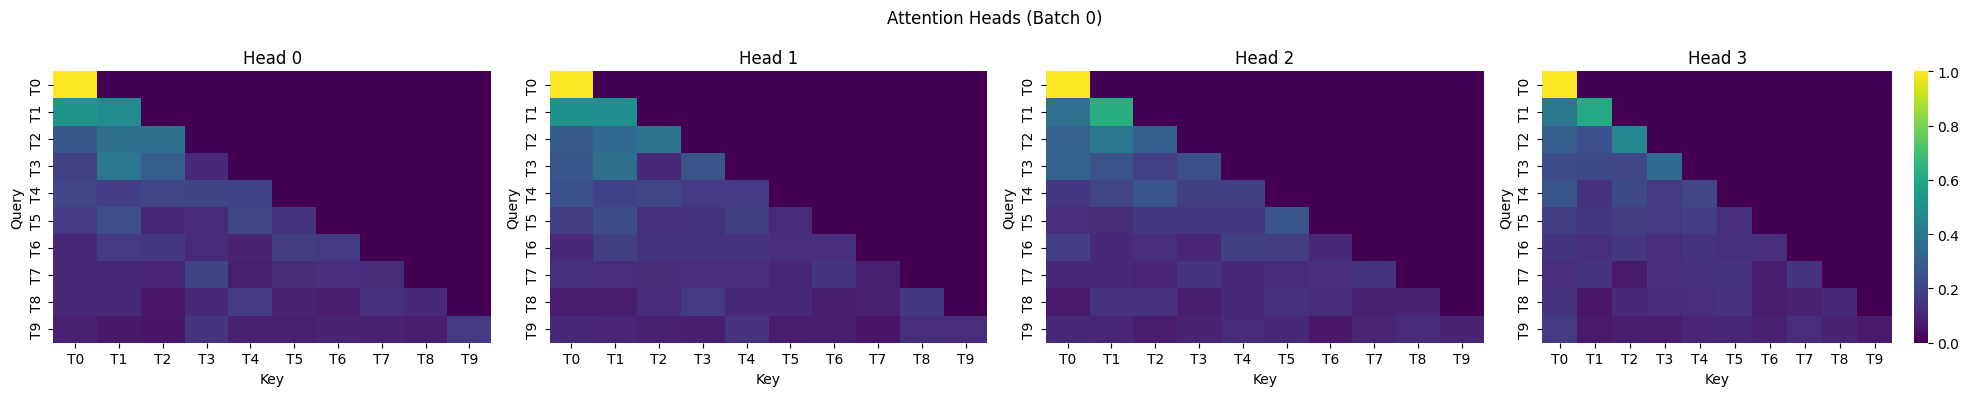

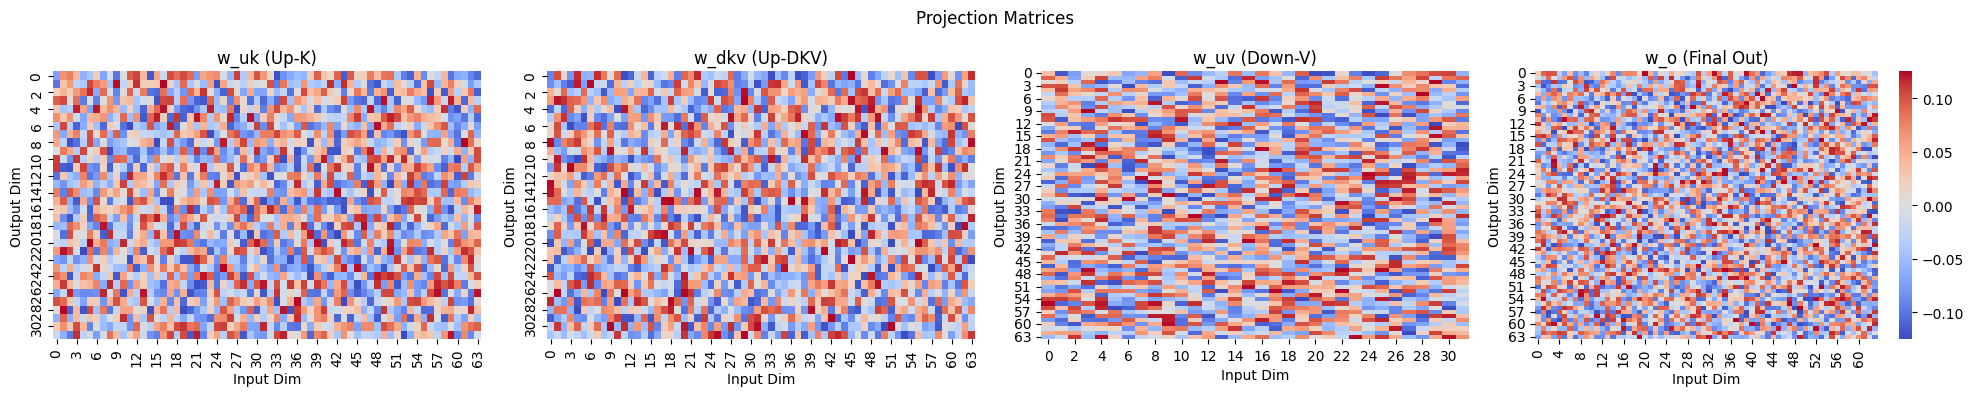

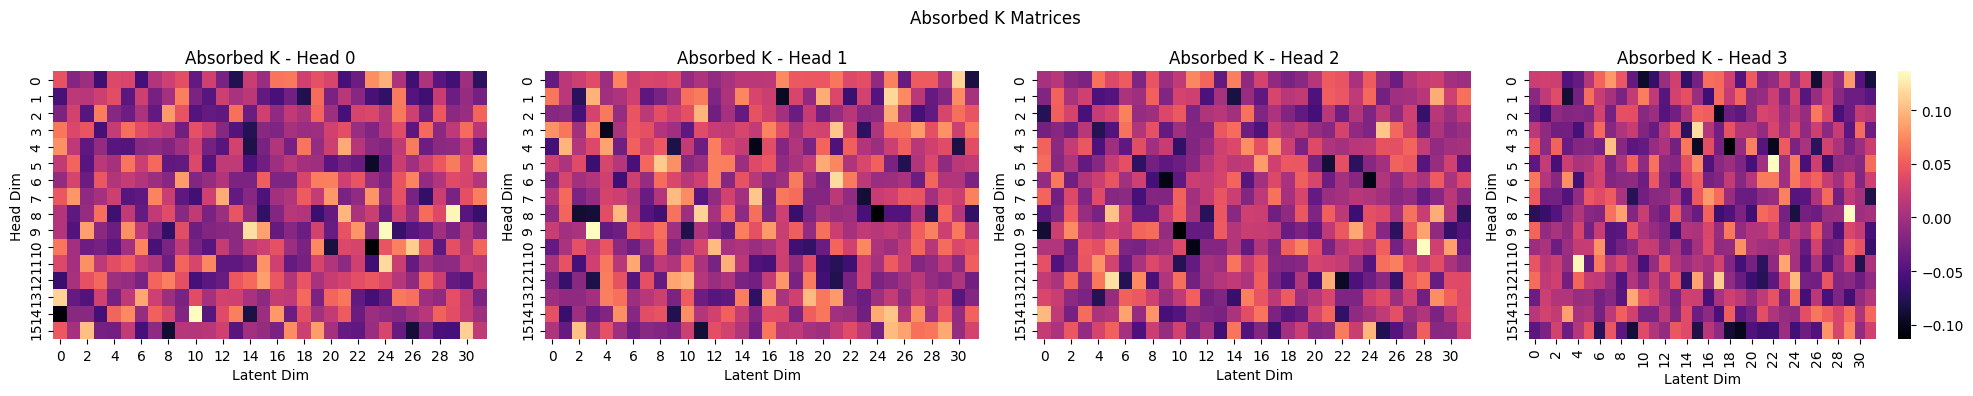

In [15]:
visualize_attention_and_projections_side_by_side(
    attn_weights=attn_weights,
    model=model,
    token_labels=[f"T{i}" for i in range(S)]
)
